In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["font.size"] = 10

import superscreen as sc
from superscreen.geometry import box

In [2]:
width = 10
height = width * 2
slot_height = height / 5
slot_width = width / 4
x0, y0 = center = (0, 0)
length_units = "um"

layer = sc.Layer("layer", Lambda=1)
film = sc.Polygon("film", layer="layer", points=box(width, height, points=501))
source_terminal = sc.Polygon(
    "source", points=box(width, height / 100, center=(0, height / 2))
)
drain_terminal = source_terminal.translate(dy=-height).set_name("drain")

device = sc.Device(
    "wire",
    layers=[layer],
    films=[film],
    terminals={film.name: [source_terminal, drain_terminal]},
    length_units=length_units,
)

In [3]:
device.make_mesh(max_edge_length=0.5, smooth=10)

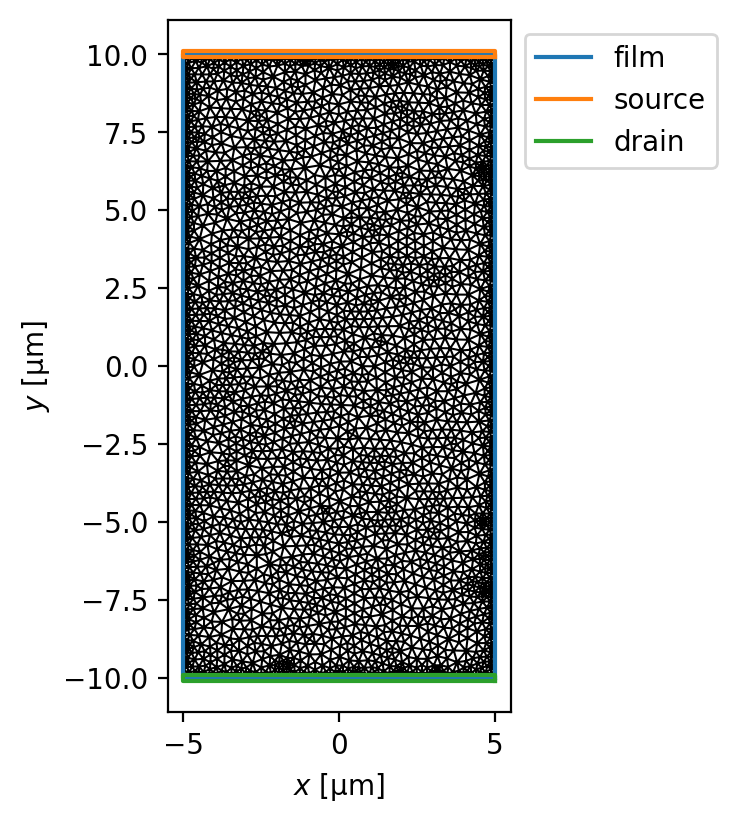

In [4]:
fig, ax = device.plot_mesh(edge_color="k")
_ = device.plot_polygons(ax=ax, legend=True)

In [5]:
terminal_currents = {"film": {"source": "1 mA", "drain": "-1 mA"}}

device.layers["layer"].Lambda = 0.2

solution = sc.solve(
    device,
    terminal_currents=terminal_currents,
    applied_field=sc.sources.ConstantField(0),
    current_units="mA",
    field_units="mT",
)[-1]

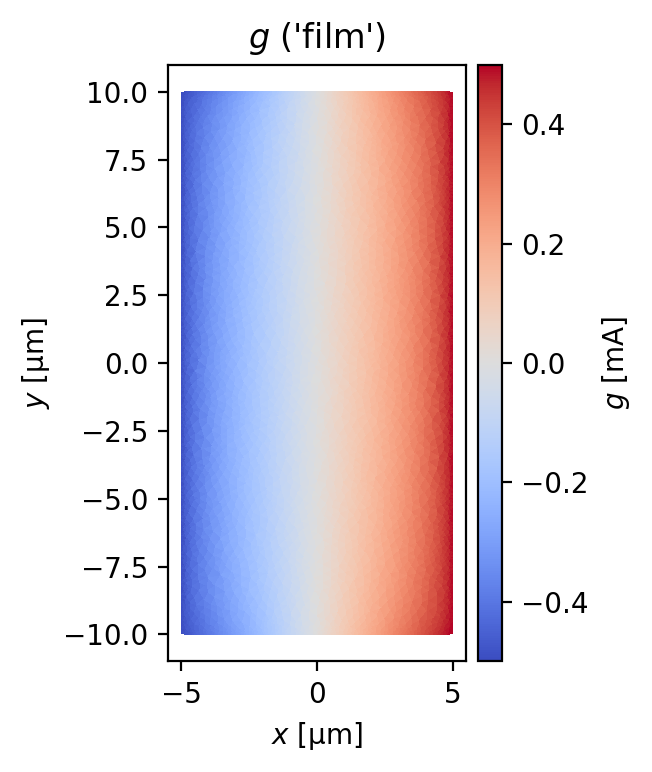

In [6]:
fig, axes = solution.plot_streams()

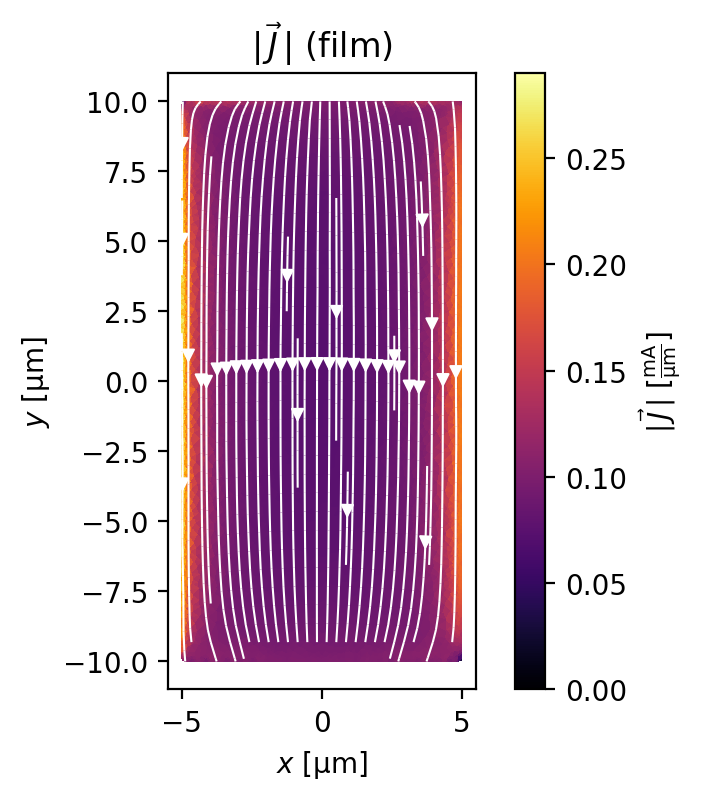

In [7]:
fig, axes = solution.plot_currents()

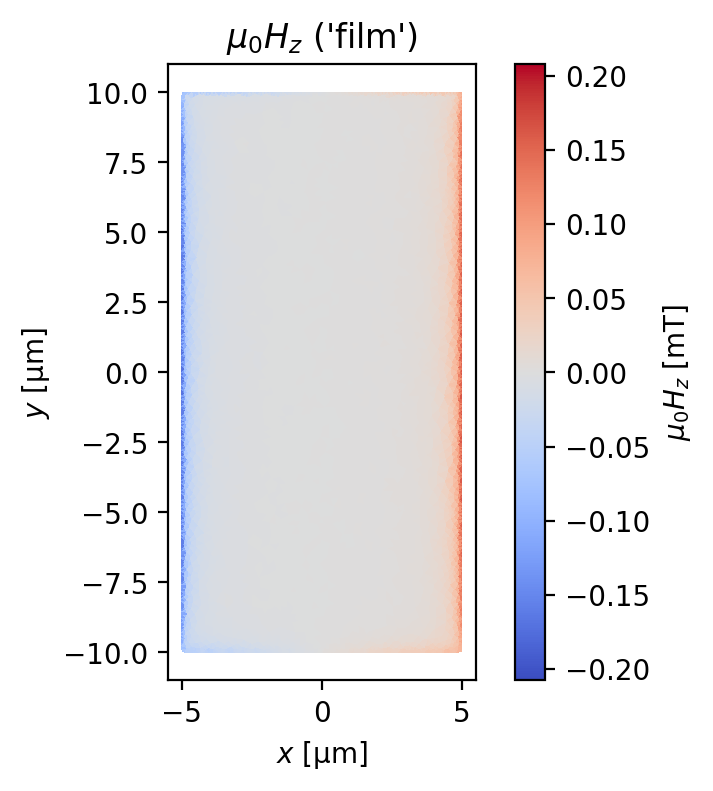

In [8]:
fig, axes = solution.plot_fields(cmap="coolwarm", symmetric_color_scale=True)

In [9]:
Lambdas = np.array([0, 0.5, 1.0, 5.0])

cut_xs = np.linspace(-6, 6, 101)
cut_ys = np.zeros_like(cut_xs)
cut_coords = np.array([cut_xs, cut_ys]).T

cut_Js = []
for Lambda in Lambdas:
    device.layers["layer"].Lambda = Lambda
    solution = sc.solve(device, terminal_currents=terminal_currents, current_units="mA")[-1]
    J = solution.interp_current_density(cut_coords, film="film", units="mA/um", with_units=False)
    cut_Js.append(np.linalg.norm(J, axis=1))

Text(0, 0.5, '$|\\,\\vec{J}\\,|$ [mA/$\\mu$m]')

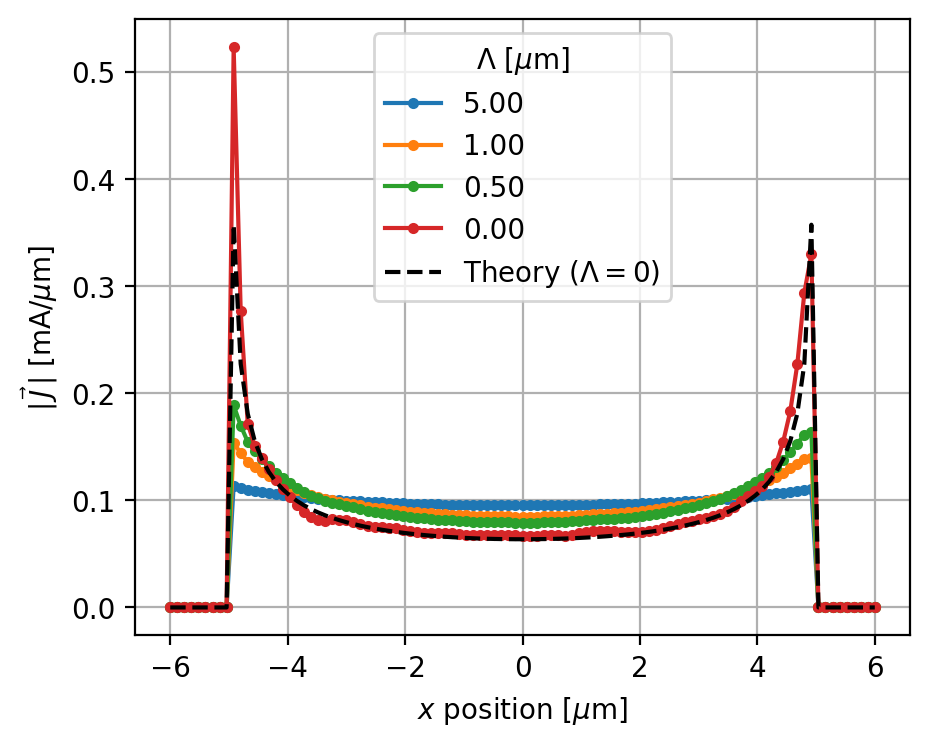

In [10]:
fig, ax = plt.subplots()

for Lambda, J in reversed(list(zip(Lambdas, cut_Js))):
    ax.plot(cut_xs, J, ".-", label=f"{Lambda:.2f}")
    
J_theory = np.real(1 / (np.pi * np.sqrt(5**2 - cut_xs**2, dtype=complex)))
ax.plot(cut_xs, J_theory, "k--", label="Theory ($\\Lambda=0$)")

ax.legend(loc=0, title="$\\Lambda$ [$\\mu$m]")
ax.grid(True)
ax.set_xlabel("$x$ position [$\\mu$m]")
ax.set_ylabel("$|\\,\\vec{J}\\,|$ [mA/$\\mu$m]")